# Project 3: House Price Prediction (Regression) 🏠

Project Objective: To build a regression model that accurately predicts the sale price of houses based on a large number of features. This project will cover the complete machine learning workflow, from deep EDA to advanced preprocessing, feature engineering, model training, and evaluation.

## Core Concepts We'll Cover:
1. Regression vs. Classification: Understanding the goal of predicting a continuous value.
2. Target Variable Analysis: Analyzing the distribution of SalePrice and applying transformations (log transform).
3. Advanced Data Preprocessing: Implementing robust strategies for handling missing values in both numerical and categorical features.
4. Feature Engineering: Creating new, powerful features from the existing data to improve model performance.
5. Categorical Encoding: Differentiating between and applying Label Encoding and One-Hot Encoding.
6. Model Building: Training and comparing a simple baseline model (Linear Regression) with an advanced model (XGBoost).
7. Model Evaluation: Understanding and using key regression metrics (RMSE, MAE, R-squared).

## Step 1: Setup - Importing Libraries and Kaggle API

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import xgboost as xgb
import os
import kagglehub
%pip install -q kaggle

sns.set_style('whitegrid')

Note: you may need to restart the kernel to use updated packages.


## Step 2: Data Loading via Kaggle API
We will load the data directly from the Kaggle competition. This is the standard and most reliable method for using Kaggle datasets in a cloud environment like Colab.

### Instructions:

1. Go to your Kaggle account page (https://www.kaggle.com/account) and click 'Create New Token' in the API section. This will download a kaggle.json file.
2. Run the code cell below. It will prompt you to upload a file. Select the kaggle.json file you just downloaded.

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.set_index("Id", inplace=True)
test_df.set_index("Id", inplace=True)

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1460, 80)
Test dataset shape: (1459, 79)


In [10]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


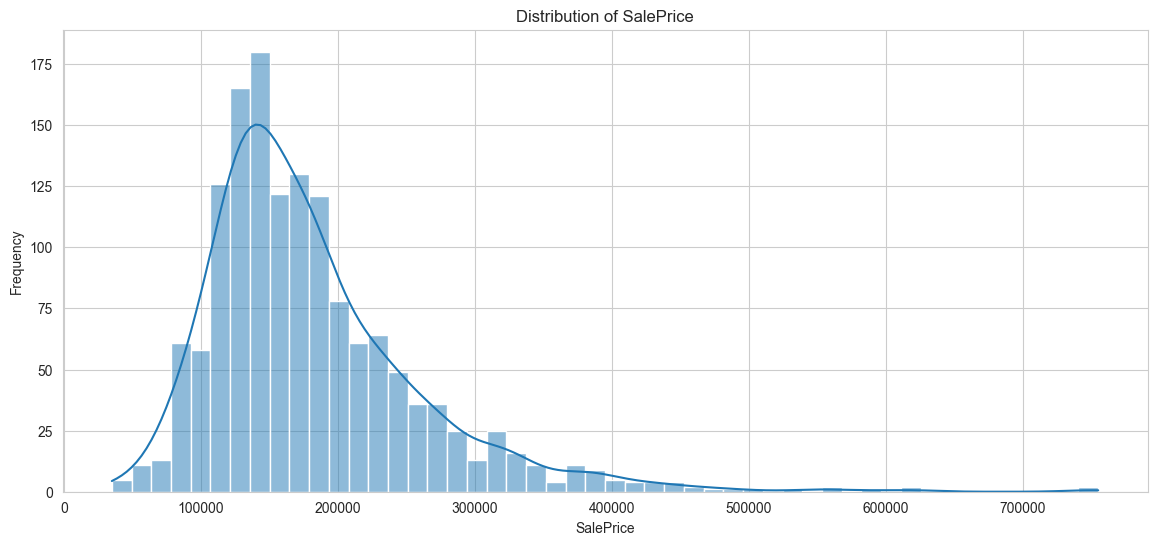

Skewness of sale price:1.8828757597682129


In [11]:
plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], bins=50, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

print(f"Skewness of sale price:{train_df.SalePrice.skew()}")

Positively skewed: long tail to the right.

* Long tail of EXPENSIVE houses.
* Model prediction can go wrong due to this skewness.

### Why?

* We are going to use Linear Regression for prediction.
* Linear Regression is very sensitive to outlier data. When we have a long tail like seen above, it can skew the results.*
* So we try to make the data as "normally distributed" as possible 

### How?
* Apply log transformation: this helps compress the range of large values, making the distribution more symmetrical.

In [12]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

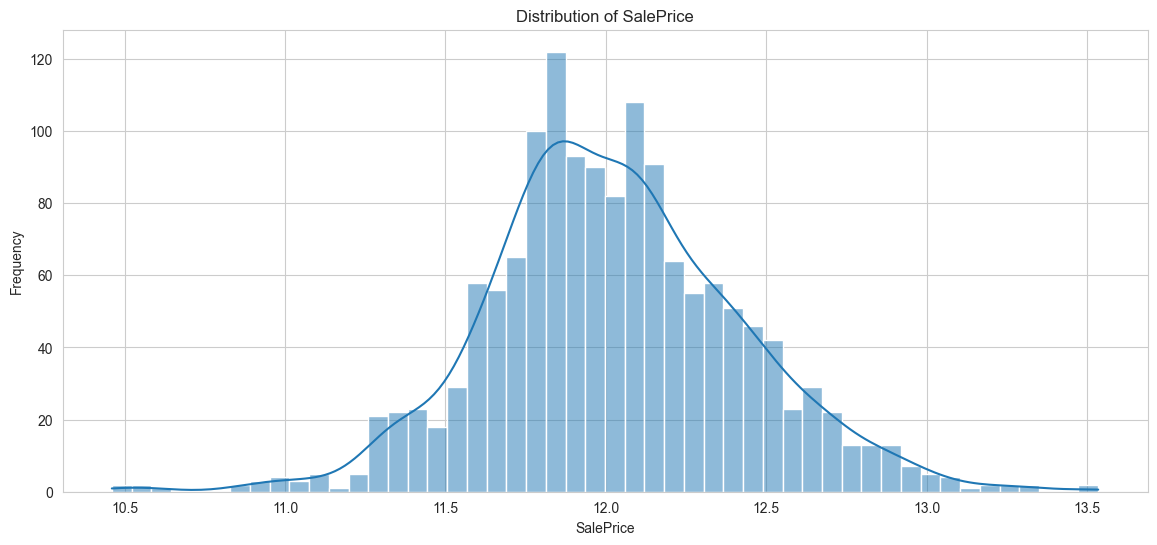

Skewness of sale price:0.12134661989685333


In [13]:
plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], bins=50, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

print(f"Skewness of sale price:{train_df.SalePrice.skew()}")

Now it's a more normal distribution. Skewness has reduced - better for our model's prediction.

## EDA on the feature variables
Finding out which variables have more affect on our target variable.

In [14]:

corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

In [15]:

top_corr_matrix

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd
SalePrice,1.000000,0.817185,0.700927,0.680625,0.650888,0.612134,0.596981,0.594771,0.586570,0.565608
OverallQual,0.817185,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.572323,0.550684
GrLivArea,0.700927,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.199010,0.287389
GarageCars,0.680625,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.537850,0.420622
GarageArea,0.650888,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.478954,0.371600
TotalBsmtSF,0.612134,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.391452,0.291066
1stFlrSF,0.596981,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.281986,0.240379
FullBath,0.594771,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.468271,0.439046
YearBuilt,0.586570,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,1.000000,0.592855
YearRemodAdd,0.565608,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.592855,1.000000


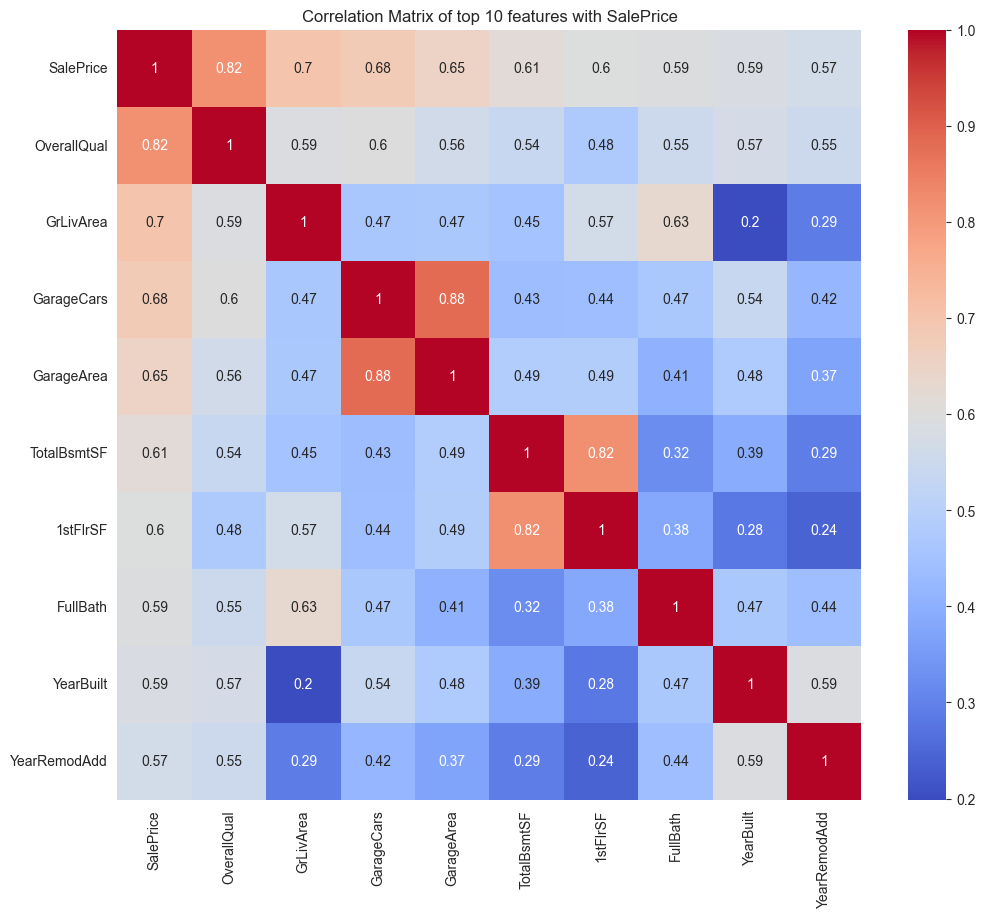

In [16]:

plt.figure(figsize=(12,10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of top 10 features with SalePrice")
plt.show()

### Observations:

OverallQual, GrLivArea and GarageArea are most positively correlated with the target variable.


### Preprocessing the data
We are combining the data so that all the preprocessing that we are about to do will be consistently applied throughout our data.

In [17]:
#Combine test and train data
data = pd.concat((train_df.loc[:,:'SaleCondition'], test_df.loc[:, :'SaleCondition']))

print(f"Combined data shape: {data.shape}")

Combined data shape: (2919, 79)


Handling missing values

In [18]:
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]
missing_data

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64

In [19]:
missing_data.shape

(34,)

The numerical values that have only few missing values can be filled with 0

In [20]:
# Impute numerical features with 0
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in data.columns:
        data[col] = data[col].fillna(0)

In [21]:

data[numerical_cols_to_impute_zero].isnull().sum()

MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
GarageCars      0
GarageArea      0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

Imputing LotFrontage with median

In [22]:
data['LotFrontage'].isnull().sum()

np.int64(486)

In [23]:

if 'LotFrontage' in data.columns and data['LotFrontage'].isnull().any():
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

For each neighborhood group, calculate the median of the existing LotFrontage values in that group and then fill the missing values within that same group with that calculated median.

In [24]:
data['LotFrontage'].isnull().sum()

np.int64(0)

In [25]:
data['Fence'].isnull().sum()
     

np.int64(2348)

In [26]:

# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in data.columns:
        data[col] = data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])

In [27]:
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in data.columns:
    data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", data.isnull().sum().sum())


Missing values after all imputation: 0


### Feature Engineering
* Need to combine square footage
* Need to combine the bathrooms
* Need to create a feature for age oh house at sale

In [28]:
# total square footage feature
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

# total bathrooms feature
data['TotalBath'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                         data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

# age of the house at sale feature
data['Age'] = data['YrSold'] - data['YearBuilt']

print("New features created.")

New features created.


Categorical encoding

In [29]:
data['Neighborhood'].value_counts()
     

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: count, dtype: int64

In [30]:
#one-hot encoding
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {data.shape}")

Data shape after encoding: (2919, 262)


Model building and training

In [31]:
# Split data into training and testing sets again
X = data[:len(train_df)]
y = train_df['SalePrice'] # SalePrice only in train_df
X_test_final = data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature scaling
Many linear models perform better when numerical features are on a similar scale.

*  Need to standardize data to have a mean of 0 and a standard deviation of 1
* Prevents features with large scales (like GrLivArea) from dominating features with small scales (like OverallQual).

In [32]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)
     

In [33]:

X_train_scaled

array([[-0.8667643 , -0.01933867, -0.21289571, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 0.07410996, -0.50039047, -0.26524463, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.63154574, -0.15053462, -0.17784146, ..., -0.12510865,
         0.46001984, -0.30263639],
       ...,
       [-0.8667643 , -0.45665849, -0.23409563, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.16110861, -0.6753184 , -0.28337613, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 1.48542135, -0.76278236, -0.65139925, ..., -0.12510865,
         0.46001984, -0.30263639]], shape=(1168, 262))

### Linear Regression
* Supervised learning algorithm
* Used for predicting a continuous target variable
* Finds the best-fitting straight line that minimizes the sum of the squared differences between the observed and predicted values

In [34]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

In [35]:
y_pred_lr

array([11.94136732, 12.73981795, 11.51734525, 12.01487948, 12.64926257,
       11.28125177, 12.42367424, 11.89852165, 11.22643455, 11.86994258,
       11.88608842, 11.64392657, 11.23230401, 12.26138536, 12.07110195,
       11.80087308, 12.14706831, 11.78972384, 11.58284822, 12.2693948 ,
       11.92793845, 12.22406554, 12.07011723, 11.82560994, 12.19616524,
       11.89526696, 12.15166979, 11.60271912, 12.10684603, 12.1969508 ,
       12.08657634, 12.53744901, 12.30214298, 11.66556937, 12.45474616,
       11.93105985, 11.89189847, 12.19935819, 12.68351764, 11.58686028,
       11.80931906, 12.29662339, 11.60207364, 12.82646513, 11.75787557,
       11.74918942, 11.57708431, 11.81620749, 13.04562787, 11.8267837 ,
       11.7062313 , 12.24629524, 11.5574877 , 12.6258775 , 12.0258037 ,
       12.38911243, 12.22142841, 11.95688407, 11.78095167, 11.50236687,
       11.30197603, 11.9977707 , 12.64750084, 12.40696689, 12.60854943,
       12.19663563, 11.60748068, 12.68077664, 11.77433401, 12.06

## XGBoost
* Gradient boosting algorithm
* Builds trees sequentially. Each new tree attempts to correct the errors made by the previous trees.the predictions from all the trees are then summed up to get the final prediction.
* Known for its performance on structured data

In [36]:

xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

### Model Evaluations
* MAE: Avg. absolute error; easy to interpret
* MSE: Avg. squared error; penalizes large errors
* RMSE: √MSE; common, same units as target
* R²: Proportion of variance explained; closer to 1 = better fit

In [37]:


def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

evaluate_model(y_val, y_pred_lr, "Linear Regression")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1344
MAE:  0.0864
R-squared: 0.9032




Observation: The XGBoost model significantly outperforms the Linear Regression model on all metrics.

In [38]:

# Make predictions on the final test set using the best model (XGBoost)
# Use the unscaled test data for XGBoost prediction
final_predictions_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('rohan_ submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
